## Gridworld inverse reinforcement learning on a Markov decision process

A Markov decision process (MDP) is a 5-tuple $(S, A, T, R, \gamma)$ with states $S$, actions $A$, transition model $T(s_t, a_t, s_{t+1}) = p(s_{t+1} \mid s_t, a_t)$, reward function $R(s_t, a_t, s_{t+1}) \in \mathbb{R}$, and reward discount factor $\gamma \in [0, 1]$ decreasing the reward over time (where $a_t \in A$ and $s_t, s_{t+1} \in S$).
In the inverse reinforcement learning setting we will only use per-state rewards $R(s) \in \mathbb{R}$.
The key part of an MDP is that any action only relies on the current state, meaning complete independence of all of the preceding history.

In [1]:
import sys, os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product # Cartesian product for iterators

# allow us to re-use the framework from the src directory
sys.path.append(os.path.abspath(os.path.join('/Users/carson/Desktop/Projects/max_ent_irl/grid_utils')))

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   
    'border': {'color': 'red', 'linewidth': 0.5},
} # global style for plots

### MDP

Now, let's create our Markov Decision Process.
We're using a square grid-world, i.e. a world with $5 \times 5$ states where an agent can move to any of the four adjacent states.

Note that this is not a full MDP as defined above, we just need the main components, i.e. the states, actions, and transition model via the `world`, the reward (per state) and a list of terminal states.

state_index 0 is the bottom left corner, the last state_index -1 is the upper right corner, state_index 1 is the square just to the right of state_index 0, as the indices go up, it wraps back around starting with the next row above

In [2]:
def setup_mdp(size=5, p_slip=0.2, terminal_index=24, reward_pairs = [(-1,1.0), (8,0.65)]):
    
    # create our world
    world = W.IcyGridWorld(size=size, p_slip=p_slip, )

    # set up the reward function
    reward = np.zeros(world.n_states)
    
    for reward_pair in reward_pairs:
        
        reward[reward_pair[0]] = reward_pair[1]

    # set up terminal states
    terminal = [terminal_index]

    return world, reward, terminal


def generate_expert_trajectories(world, reward, terminal):
    
    n_trajectories = 200         # the number of "expert" trajectories
    discount = 0.9               # discount for constructing an "expert" policy
    weighting = lambda x: x**50  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value = S.value_iteration(world.p_transition, reward, discount)
    
    # create our stochastic policy using the value function
    policy = S.stochastic_policy_from_value(world, value, w=weighting)
    
    # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = T.stochastic_policy_adapter(policy)
    
    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))
    
    return tjs, policy


In [24]:
# set-up the GridWorld Markov Decision Process
world, reward, terminal = setup_mdp(size=5, p_slip=0.0, terminal_index=9, reward_pairs = [(9,1.0), (13,.9)])

# generate some "expert" trajectories (and its policy for visualization)
trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)


<IPython.core.display.Javascript object>


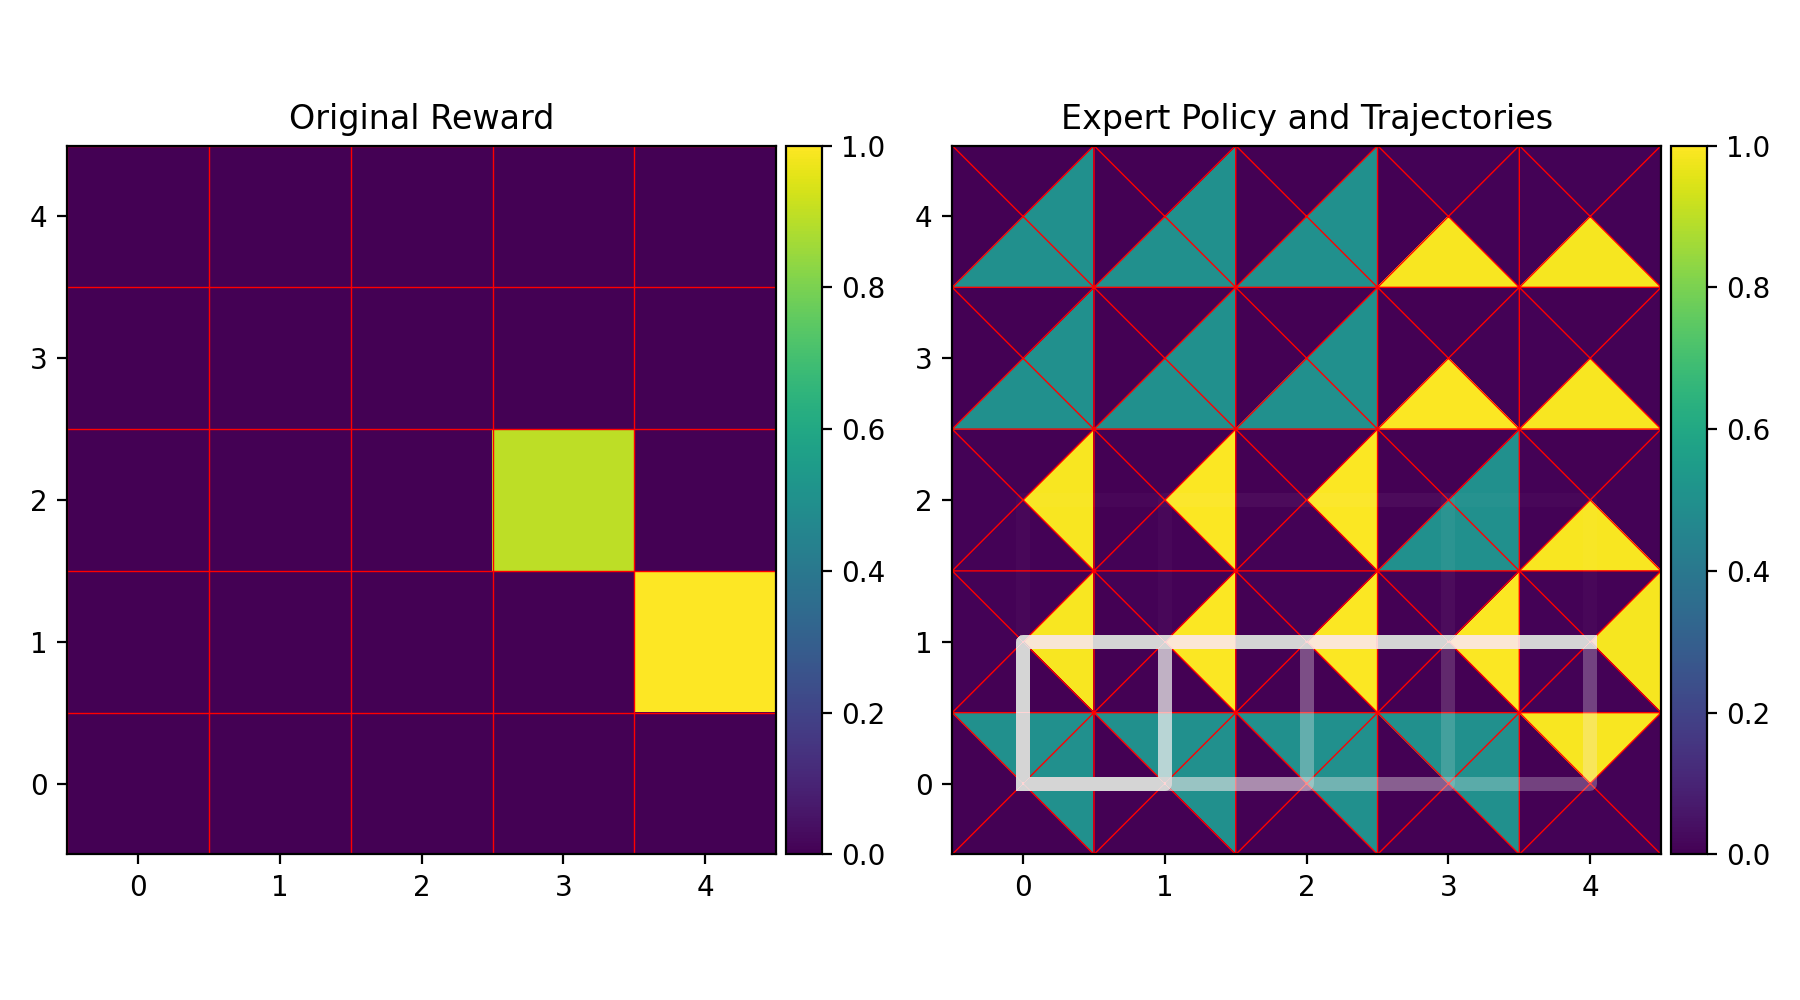

In [25]:
fig = plt.figure()

ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_stochastic_policy(ax, world, expert_policy, **style)
fig.colorbar(p, cax=cax)

for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)

fig.tight_layout()
plt.show()

## Actions 

action_index = 0 means move to the right,

action_index = 1 means move to the left, 

action_index = 2 means move up,

action_index = 3 means move down,

In [37]:
# For example, state index 6 is the square just up and to the right of the lower left corner

for a in [0,1,2,3]:
    
    print(a, world.state_index_transition(s=6, a=a))

0 7
1 5
2 11
3 1


## Trajectories

trajectories is a list where each element's .transitions() is a list of tuples

`(state_from, action, state_to)` Where `state_to` of
an entry should always be equal to `state_from` of the next entry.

In [27]:
tj = trajectories[0].transitions()

print(tj, len(tj), tj[0])

[(0, 2, 5), (5, 0, 6), (6, 2, 11), (11, 0, 12), (12, 0, 13), (13, 0, 14), (14, 3, 9)] 7 (0, 2, 5)


[(0, 0, 1),
 (1, 0, 2),
 (2, 0, 3),
 (3, 2, 8),
 (8, 2, 13),
 (13, 2, 18),
 (18, 2, 23),
 (23, 0, 24)]